In [239]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [240]:
df = pd.read_csv('supermarket.csv')
df.tail(3)

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,...,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
578079,200637,20061109,5,16,1,4.47,PRD0900396,CL00229,DEP00081,G00027,...,UM,NaN,994103100229855,L,MM,Full Shop,Mixed,STORE00001,LS,E02
578080,200717,20070624,1,10,1,4.92,PRD0903065,CL00229,DEP00081,G00027,...,UM,YF,994106300437841,L,MM,Full Shop,Mixed,STORE00001,LS,E02
578081,200744,20071229,7,14,1,9.27,PRD0901923,CL00229,DEP00081,G00027,...,UM,NaN,994109000359411,L,MM,Top Up,Mixed,STORE00001,LS,E02


In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578082 entries, 0 to 578081
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SHOP_WEEK                 578082 non-null  int64  
 1   SHOP_DATE                 578082 non-null  int64  
 2   SHOP_WEEKDAY              578082 non-null  int64  
 3   SHOP_HOUR                 578082 non-null  int64  
 4   QUANTITY                  578082 non-null  int64  
 5   SPEND                     578082 non-null  float64
 6   PROD_CODE                 578082 non-null  object 
 7   PROD_CODE_10              578082 non-null  object 
 8   PROD_CODE_20              578082 non-null  object 
 9   PROD_CODE_30              578082 non-null  object 
 10  PROD_CODE_40              578082 non-null  object 
 11  CUST_CODE                 492494 non-null  object 
 12  CUST_PRICE_SENSITIVITY    492494 non-null  object 
 13  CUST_LIFESTAGE            433142 non-null  o

In [242]:
# Found missing values on CUST_CODE, CUST_PRICE_SENSITIVITY, CUST_LIFESTAGE columns
df.isna().sum()

SHOP_WEEK                        0
SHOP_DATE                        0
SHOP_WEEKDAY                     0
SHOP_HOUR                        0
QUANTITY                         0
SPEND                            0
PROD_CODE                        0
PROD_CODE_10                     0
PROD_CODE_20                     0
PROD_CODE_30                     0
PROD_CODE_40                     0
CUST_CODE                    85588
CUST_PRICE_SENSITIVITY       85588
CUST_LIFESTAGE              144940
BASKET_ID                        0
BASKET_SIZE                      0
BASKET_PRICE_SENSITIVITY         0
BASKET_TYPE                      0
BASKET_DOMINANT_MISSION          0
STORE_CODE                       0
STORE_FORMAT                     0
STORE_REGION                     0
dtype: int64

In [243]:
# Clean missing values
df.dropna(subset=['CUST_CODE'], inplace=True)
df['CUST_LIFESTAGE'] = df['CUST_LIFESTAGE'].fillna('XX')
df.isna().sum()

SHOP_WEEK                   0
SHOP_DATE                   0
SHOP_WEEKDAY                0
SHOP_HOUR                   0
QUANTITY                    0
SPEND                       0
PROD_CODE                   0
PROD_CODE_10                0
PROD_CODE_20                0
PROD_CODE_30                0
PROD_CODE_40                0
CUST_CODE                   0
CUST_PRICE_SENSITIVITY      0
CUST_LIFESTAGE              0
BASKET_ID                   0
BASKET_SIZE                 0
BASKET_PRICE_SENSITIVITY    0
BASKET_TYPE                 0
BASKET_DOMINANT_MISSION     0
STORE_CODE                  0
STORE_FORMAT                0
STORE_REGION                0
dtype: int64

In [244]:
df[['QUANTITY', 'SPEND']].describe().apply(lambda x: x.apply('{0:.5f}'.format)).transpose()

,count,mean,std,min,25%,50%,75%,max
QUANTITY,492494.00000,1.52764,1.57281,1.00000,1.00000,1.00000,1.00000,129.00000
SPEND,492494.00000,1.92788,2.69127,0.01000,0.77000,1.24000,2.11000,346.46000


In [245]:
# clean data type
df['SHOP_DATE'] = pd.to_datetime(df['SHOP_DATE'], format='%Y%m%d')
df['SHOP_MONTH'] = df['SHOP_DATE'].dt.to_period('m')

In [246]:
print(f"min date :{df['SHOP_DATE'].min()}")
print(f"max date :{df['SHOP_DATE'].max()}")

min date :2006-04-10 00:00:00
max date :2008-07-06 00:00:00


In [247]:
cust_filter = df.groupby('CUST_CODE').agg(num_bkt = ('BASKET_ID', 'nunique')).reset_index()
cust_filter = cust_filter.loc[cust_filter['num_bkt']!=1, :]['CUST_CODE']

In [248]:
df = df.loc[df['CUST_CODE'].isin(cust_filter), :]

In [249]:
# # filter churn customers out
# # remove customers who inactive more than one month
# print(f"before churn filter :{df['CUST_CODE'].nunique()}")

# cust_active = list(df.loc[df['SHOP_MONTH'] >= (df['SHOP_MONTH'].max() - 1), :]['CUST_CODE'].unique())
# df = df.loc[df['CUST_CODE'].isin(cust_active), :]

# print(f"after churn filter :{df['CUST_CODE'].nunique()}")

In [250]:
# create feature df
df_clus = df[['CUST_CODE']].drop_duplicates().reset_index(drop=True)

df_clus = df_clus.merge(
    df.groupby(['CUST_CODE', 'BASKET_ID']).agg(
    spend = ('SPEND', 'sum'),
    date_min = ('SHOP_DATE', 'min'),
    date_max = ('SHOP_DATE', 'max')).reset_index().groupby('CUST_CODE').agg(bkt_size = ('spend', 'mean'), 
                                                                    num_trans = ('spend', 'count'),
                                                                    total_spend = ('spend', 'sum'),
                                                                    date_min = ('date_min', 'min'),
                                                                    date_max = ('date_max', 'max')),
    how='left', on='CUST_CODE')

df_clus = df_clus.merge(
    df.loc[df['SHOP_MONTH'] > (df['SHOP_MONTH'].max() - 3), :].groupby(['CUST_CODE', 'BASKET_ID']).agg(
    spend = ('SPEND', 'sum')).reset_index().groupby('CUST_CODE').agg(bkt_size_3m = ('spend', 'mean'), 
                                                                    num_trans_3m = ('spend', 'count'),
                                                                    total_spend_3m = ('spend', 'sum')),
    how='left', on='CUST_CODE')

df_clus = df_clus.merge(
    df.loc[df['SHOP_MONTH'] > (df['SHOP_MONTH'].max() - 6), :].groupby(['CUST_CODE', 'BASKET_ID']).agg(
    spend = ('SPEND', 'sum')).reset_index().groupby('CUST_CODE').agg(bkt_size_6m = ('spend', 'mean'), 
                                                                    num_trans_6m = ('spend', 'count'),
                                                                    total_spend_6m = ('spend', 'sum')),
    how='left', on='CUST_CODE')

df_clus['tbp'] = (df_clus['date_max']-df_clus['date_min']).dt.days / df_clus['num_trans']
df_clus['mem_dur'] = (df['SHOP_DATE'].max()-df_clus['date_min']).dt.days
df_clus['spending_per_day'] = df_clus['total_spend']/df_clus['mem_dur']
df_clus['trans_per_day'] = df_clus['num_trans']/df_clus['mem_dur']

df_clus.drop(columns=['date_min', 'total_spend', 'num_trans', 'date_max'], inplace=True)

df_clus.tail(3)

,CUST_CODE,bkt_size,bkt_size_3m,num_trans_3m,total_spend_3m,bkt_size_6m,num_trans_6m,total_spend_6m,tbp,mem_dur,spending_per_day,trans_per_day
2413,CUST0000078129,1.54,NaN,NaN,NaN,NaN,NaN,NaN,172.0,566,0.005442,0.003534
2414,CUST0000134441,0.92,NaN,NaN,NaN,0.92,1.0,0.92,233.0,553,0.003327,0.003617
2415,CUST0000401800,0.01,0.01,1.0,0.01,0.01,2.0,0.02,40.0,118,0.000169,0.016949


In [251]:
df_clus.describe()

,bkt_size,bkt_size_3m,num_trans_3m,total_spend_3m,bkt_size_6m,num_trans_6m,total_spend_6m,tbp,mem_dur,spending_per_day,trans_per_day
count,2416.000000,1356.000000,1356.000000,1356.000000,1761.000000,1761.000000,1761.000000,2416.000000,2416.000000,2416.000000,2416.000000
mean,13.670696,14.769183,4.035398,59.885236,14.180875,7.218058,104.202010,66.329022,622.681291,0.539298,0.037426
std,14.169208,17.626689,5.755556,95.538443,16.562440,12.186623,187.088519,69.940500,192.093456,1.034538,0.067552
min,0.010000,0.010000,1.000000,0.010000,0.010000,1.000000,0.010000,0.000000,92.000000,0.000030,0.002445
25%,4.208137,3.492500,1.000000,5.295000,3.530000,1.000000,6.070000,16.111837,508.000000,0.035220,0.005995
50%,9.897000,9.551250,2.000000,21.350000,9.270000,3.000000,28.800000,43.281250,681.000000,0.139723,0.012780
75%,19.207237,19.850714,4.000000,67.067500,19.442857,7.000000,106.340000,89.477679,787.000000,0.502759,0.034406
max,306.970000,306.970000,62.000000,885.630000,306.970000,129.000000,1893.210000,402.500000,818.000000,10.124279,0.762836


In [252]:
df_clus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2416 entries, 0 to 2415
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CUST_CODE         2416 non-null   object 
 1   bkt_size          2416 non-null   float64
 2   bkt_size_3m       1356 non-null   float64
 3   num_trans_3m      1356 non-null   float64
 4   total_spend_3m    1356 non-null   float64
 5   bkt_size_6m       1761 non-null   float64
 6   num_trans_6m      1761 non-null   float64
 7   total_spend_6m    1761 non-null   float64
 8   tbp               2416 non-null   float64
 9   mem_dur           2416 non-null   int64  
 10  spending_per_day  2416 non-null   float64
 11  trans_per_day     2416 non-null   float64
dtypes: float64(10), int64(1), object(1)
memory usage: 245.4+ KB


In [253]:
df_clus = df_clus.fillna(0)

In [254]:
# df_group = df.groupby('CUST_CODE').agg({'SHOP_DATE': lambda x: (df['SHOP_DATE'].max() - x.max()).days,
#                             'SPEND': lambda x: x.sum(),
#                             'BASKET_ID': lambda x: x.nunique()
#                             }).reset_index()

# df_group.columns=['CUST_CODE','recency','total_spent', 'num_bkt']

# # Average Order Value
# df_group['bkt_size']=df_group['total_spent']/df_group['num_bkt']

# # Purchase Frequency
# purchase_frequency=sum(df_group['num_bkt'])/df_group.shape[0]

# # Repeat Rate
# repeat_rate=df_group[df_group.num_bkt > 1].shape[0]/df_group.shape[0]

# #Churn Rate
# churn_rate=1-repeat_rate

# # Customer Value
# df_group['clv']=(df_group['bkt_size']*purchase_frequency)/churn_rate

# # Time Between Purchase
# customer_lifespan = (df['SHOP_DATE'].max() - df['SHOP_DATE'].min()).days
# df_group['tbp'] = customer_lifespan/df_group['num_bkt']

# df_group.tail(3)

## K-Mean Clustering

In [255]:
X = df_clus.drop(columns='CUST_CODE')

scaler = StandardScaler()
X = scaler.fit_transform(X)

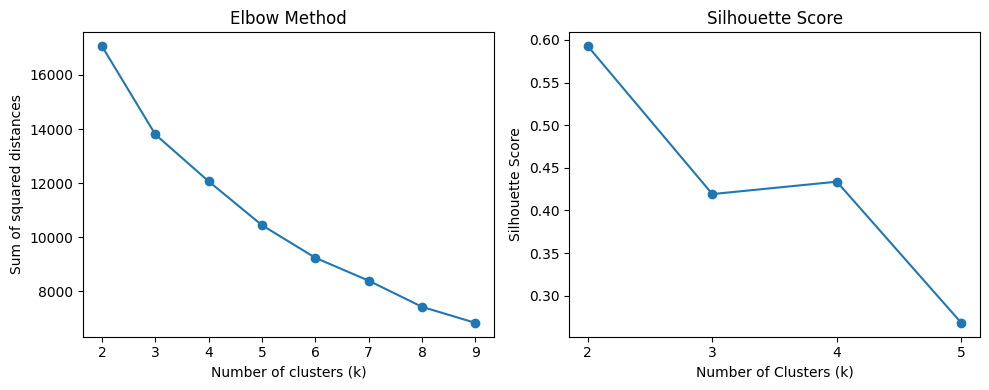

In [256]:
### Elbow
k_values = range(2, 10)
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)


### Silhouette
silhouette_scores = []

for k in range(2, 6):
    # Create a KMeans object and fit the data
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)

    # Get the cluster labels for each sample
    labels = kmeans.labels_

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

axes[0].plot(k_values, inertia_values, marker='o')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Sum of squared distances')
axes[0].set_title('Elbow Method')

axes[1].plot(range(2, 6), silhouette_scores, marker='o')
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_xticks(range(2, 6))

plt.show()

In [257]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)

# Get cluster labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Add cluster labels to the DataFrame
df_clus['Cluster'] = labels
df_clus.tail(3)

,CUST_CODE,bkt_size,bkt_size_3m,num_trans_3m,total_spend_3m,bkt_size_6m,num_trans_6m,total_spend_6m,tbp,mem_dur,spending_per_day,trans_per_day,Cluster
2413,CUST0000078129,1.54,0.00,0.0,0.00,0.00,0.0,0.00,172.0,566,0.005442,0.003534,0
2414,CUST0000134441,0.92,0.00,0.0,0.00,0.92,1.0,0.92,233.0,553,0.003327,0.003617,0
2415,CUST0000401800,0.01,0.01,1.0,0.01,0.01,2.0,0.02,40.0,118,0.000169,0.016949,0


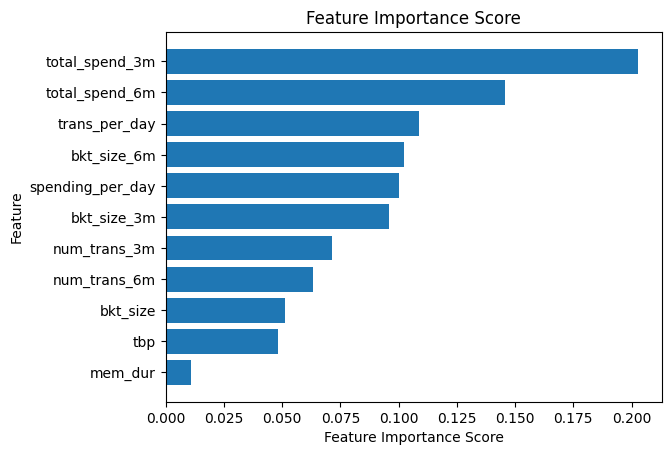

In [258]:
# Create a Random Forest classifier
clf = RandomForestClassifier(random_state=42)

# Train the classifier on your data
clf.fit(X, labels)

# Get the feature importance scores
importance_scores = clf.feature_importances_

# Sort the features based on importance in descending order
sorted_indices = np.argsort(importance_scores)[::-1]

# # Print the feature rankings
# for i, idx in enumerate(sorted_indices):
#     print(f"Rank {i}: Feature {df_clus.columns[idx]}, Importance score: {importance_scores[idx]}")

# Plotting the feature importance
plt.barh(range(len(sorted_indices)), importance_scores[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [df_clus.columns[idx+1] for idx in sorted_indices])
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance Score')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()

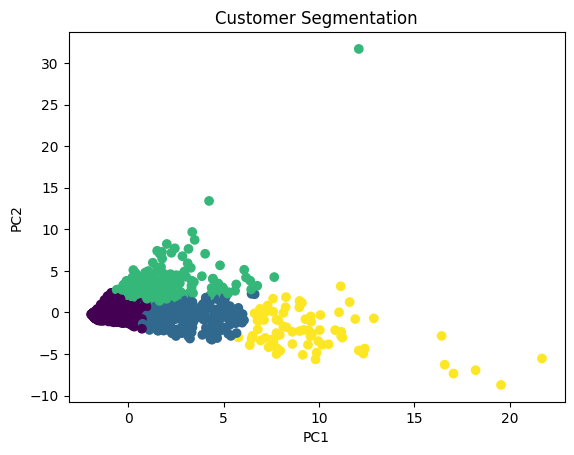

In [259]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Customer Segmentation')

# plt.legend(handles=scatter.legend_elements()[0], labels=set(labels), title='Labels')

# Show the plot
plt.show()

In [260]:
df_clus['Cluster'].value_counts()

0    1885
1     264
2     192
3      75
Name: Cluster, dtype: int64

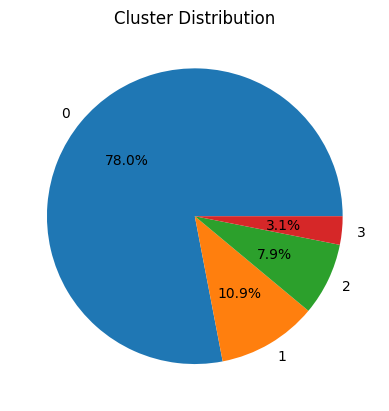

In [261]:
cluster_counts = df_clus['Cluster'].value_counts()

# Create a pie chart
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%')

# Add a title to the chart
plt.title('Cluster Distribution')

# Display the chart
plt.show()

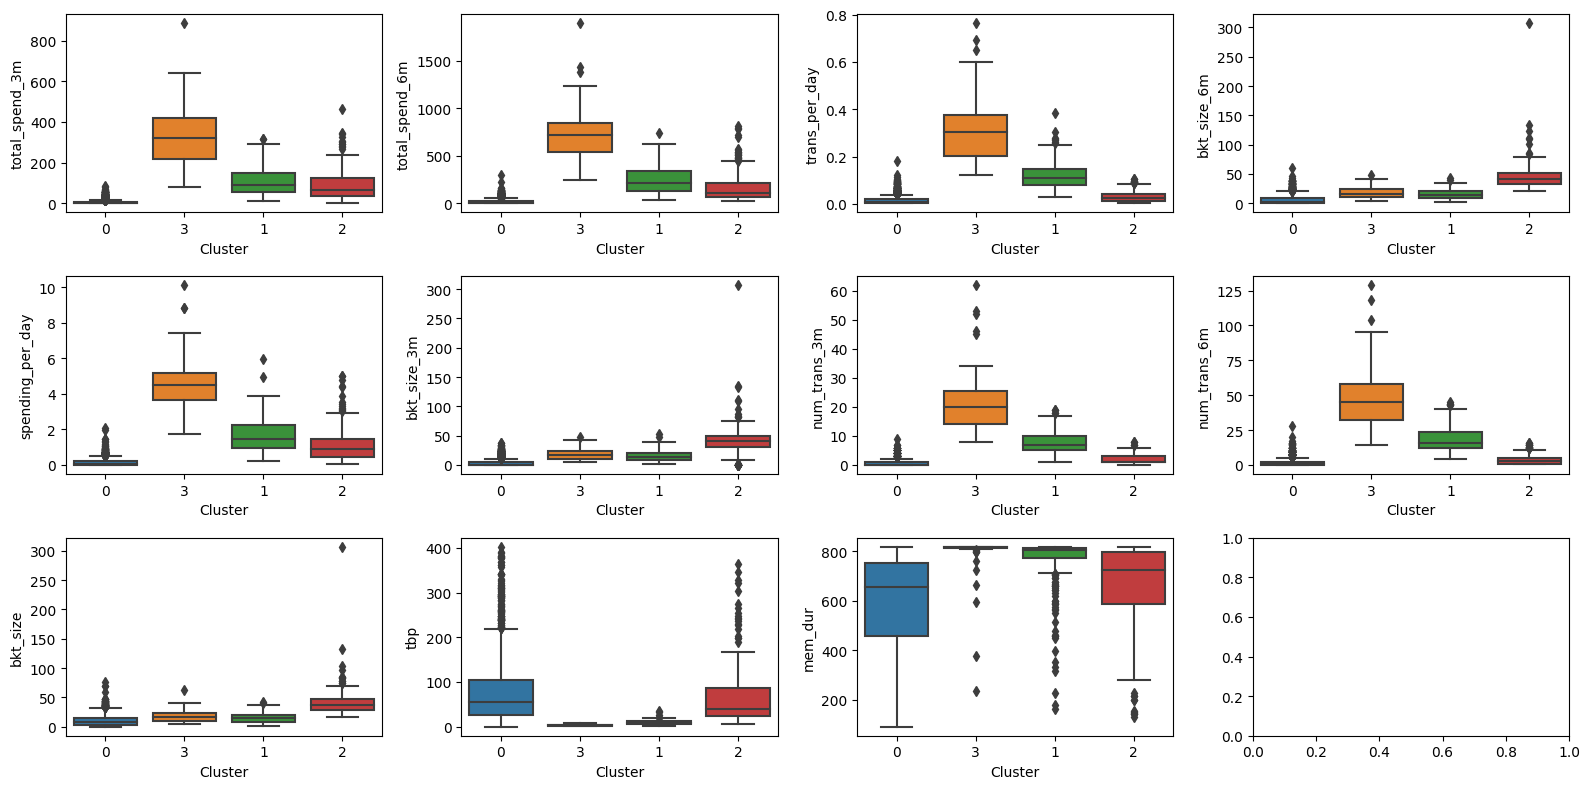

In [262]:
df_clus['Cluster'] = df_clus['Cluster'].astype(str)
num_var = df_clus.select_dtypes(include=['float64', 'int64']).columns.to_list()
column = [num_var[idx] for idx in sorted_indices]

fig, axes = plt.subplots(3, 4, figsize=(16,8), tight_layout=True)
row = 0
col = 0
for feature in column:
    sns.boxplot(data=df_clus, y=feature, x='Cluster', ax=axes[row, col])
    col += 1
    if col == 4:
        col = 0
        row += 1
plt.show()

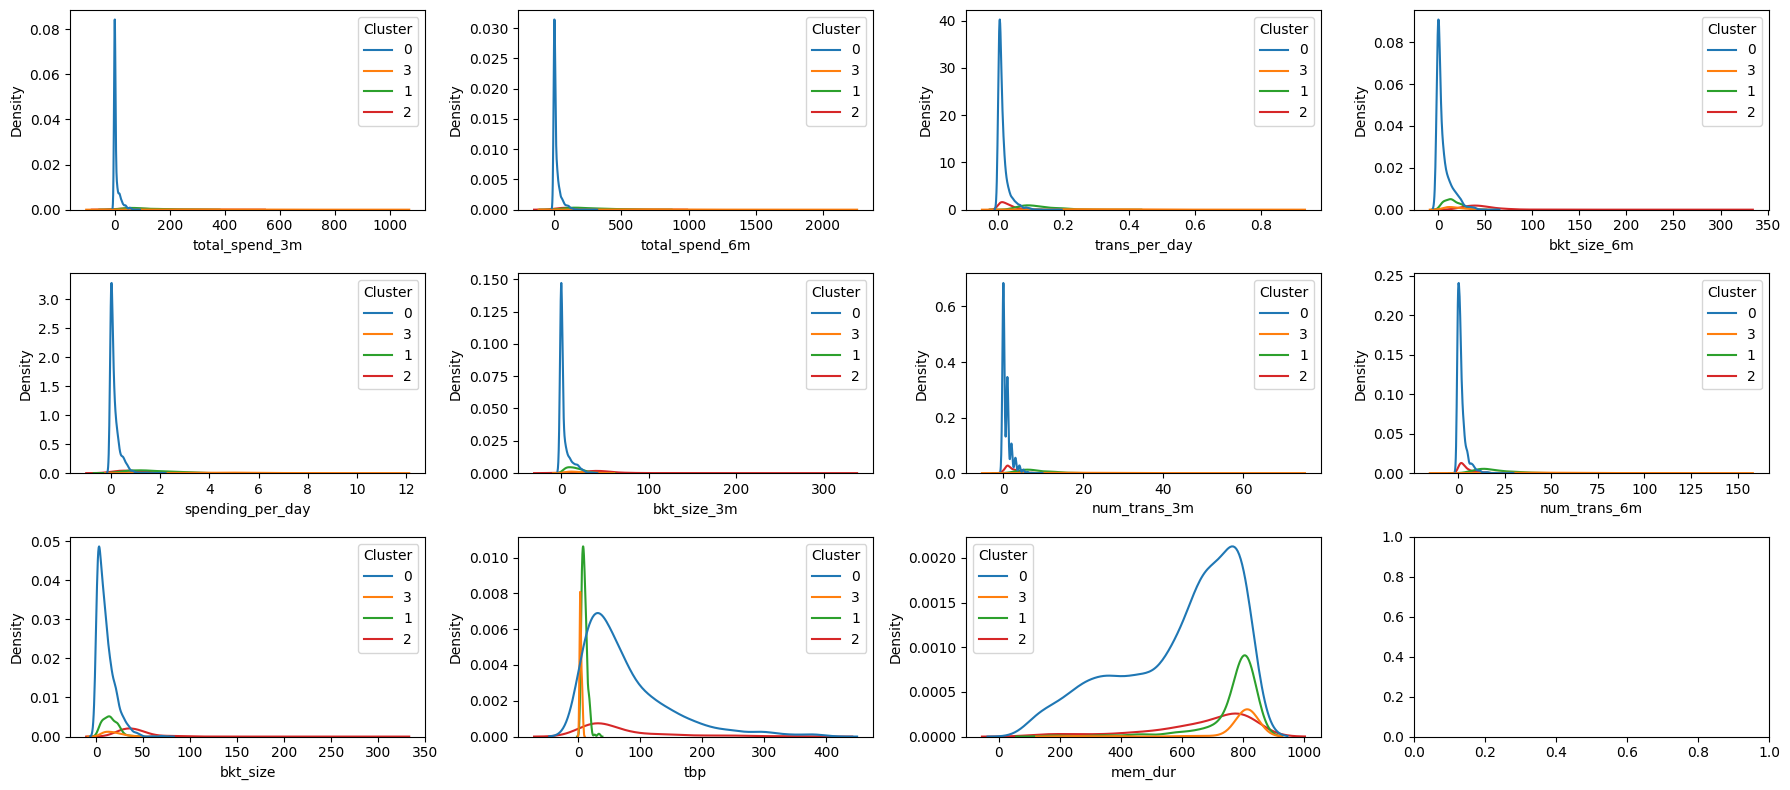

In [263]:
fig, axes = plt.subplots(3, 4, figsize=(18,8), tight_layout=True)
row = 0
col = 0
for feature in column:
    sns.kdeplot(data=df_clus, x=feature, hue='Cluster', ax=axes[row, col])
    col += 1
    if col == 4:
        col = 0
        row += 1
plt.show()

In [264]:
from IPython.display import HTML

desc = df_clus.groupby('Cluster').describe()
for col in column:
    display(HTML(f"{col.upper()}"))
    display(desc[col].style.bar(color='turquoise'))
    display(HTML(''))

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,1885.000000,5.836393,11.300151,0.000000,0.000000,0.000000,6.550000,84.570000
1,264.000000,105.365379,66.971358,10.240000,54.057500,88.305000,150.742500,315.480000
2,192.000000,89.404375,79.271453,0.000000,35.937500,65.115000,126.692500,463.490000
3,75.000000,336.275733,147.021645,82.340000,216.500000,322.250000,420.365000,885.630000


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,1885.000000,15.653109,26.861908,0.000000,0.000000,2.910000,20.590000,301.540000
1,264.000000,247.495265,140.395525,30.700000,133.842500,216.515000,339.807500,734.930000
2,192.000000,174.550729,164.136694,21.730000,66.312500,112.785000,216.845000,816.440000
3,75.000000,735.215200,285.039655,243.760000,534.290000,719.000000,843.850000,1893.210000


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,1885.000000,0.015703,0.017002,0.002445,0.005188,0.009419,0.018868,0.183007
1,264.000000,0.121395,0.054554,0.028894,0.080955,0.108572,0.148103,0.382609
2,192.000000,0.029747,0.024505,0.002646,0.010209,0.023237,0.040361,0.106965
3,75.000000,0.307473,0.134893,0.122807,0.203067,0.303178,0.376147,0.762836


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,1885.000000,5.665321,7.980166,0.000000,0.000000,2.060000,8.460000,59.880000
1,264.000000,15.057034,8.112032,1.461905,8.911160,14.065561,20.513229,43.231176
2,192.000000,46.644297,26.020965,21.691667,33.015000,41.441667,52.057500,306.970000
3,75.000000,18.168400,10.049234,3.996066,10.700033,16.304884,24.369951,48.387727


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,1885.000000,0.160922,0.205561,0.000030,0.024939,0.082602,0.220463,2.094506
1,264.000000,1.641842,0.907810,0.209292,0.939198,1.452305,2.253968,5.954007
2,192.000000,1.145538,1.017213,0.076190,0.428575,0.887961,1.448229,5.020723
3,75.000000,4.616211,1.571565,1.769177,3.666326,4.477574,5.175959,10.124279


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,1885.000000,3.479849,6.225166,0.000000,0.000000,0.000000,4.370000,37.210000
1,264.000000,15.216372,9.093877,1.505000,7.906714,13.739945,21.056625,52.580000
2,192.000000,41.923592,29.480283,0.000000,31.446875,40.375000,49.330000,306.970000
3,75.000000,18.680593,10.682500,4.361613,10.383370,16.491765,24.304952,47.200000


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,1885.000000,0.758621,1.134101,0.000000,0.000000,0.000000,1.000000,9.000000
1,264.000000,7.791667,3.752587,1.000000,5.000000,7.000000,10.000000,19.000000
2,192.000000,1.994792,1.596781,0.000000,1.000000,1.000000,3.000000,8.000000
3,75.000000,21.360000,10.564653,8.000000,14.000000,20.000000,25.500000,62.000000


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,1885.000000,1.792573,2.519552,0.000000,0.000000,1.000000,2.000000,28.000000
1,264.000000,18.526515,8.973941,4.000000,12.000000,16.000000,24.000000,45.000000
2,192.000000,4.083333,3.672928,1.000000,1.000000,3.000000,5.000000,16.000000
3,75.000000,48.760000,23.024570,14.000000,32.000000,45.000000,58.000000,129.000000


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,1885.000000,10.462136,9.393082,0.010000,3.245946,7.716000,14.900000,76.450000
1,264.000000,14.864029,7.707250,1.478125,8.802364,14.161743,20.466823,42.618158
2,192.000000,41.815562,25.267186,15.878571,29.388938,37.034589,46.518980,306.970000
3,75.000000,18.061117,10.230908,3.840293,10.346167,16.983097,24.040013,63.061667


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,1885.000000,76.302177,70.719792,0.000000,27.000000,54.750000,104.333333,402.500000
1,264.000000,9.846230,4.544736,2.431818,6.641029,9.020545,12.156061,34.347826
2,192.000000,70.478049,74.485876,6.714286,22.955214,40.291667,85.616071,363.500000
3,75.000000,3.868314,1.641948,1.310897,2.645517,3.287449,4.870482,8.142857


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,1885.000000,592.798939,192.931443,92.000000,457.000000,654.000000,754.000000,818.000000
1,264.000000,762.356061,108.434146,164.000000,773.250000,806.000000,815.000000,818.000000
2,192.000000,656.984375,177.935322,132.000000,586.250000,724.500000,798.000000,817.000000
3,75.000000,794.253333,88.461489,235.000000,813.000000,816.000000,817.000000,818.000000


In [265]:
# df_clus['Cluster'] = df_clus['Cluster'].astype(str)
# num_var = df_clus.select_dtypes(include=['float64', 'int64']).columns.to_list()
# column = [num_var[idx] for idx in sorted_indices]

# for i in column:
#     fig, ax = plt.subplots()
#     ax.boxplot([df_clus[df_clus['Cluster'] == '0'][i],
#                 df_clus[df_clus['Cluster'] == '1'][i],
#                 df_clus[df_clus['Cluster'] == '2'][i],
#                 df_clus[df_clus['Cluster'] == '3'][i]
#                 ])
#     ax.set_xticklabels(['0', '1','2','3'])
#     ax.set_ylabel(i)
#     plt.show()

In [266]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       383
           1       0.92      0.94      0.93        52
           2       0.96      0.84      0.90        32
           3       1.00      0.94      0.97        17

    accuracy                           0.98       484
   macro avg       0.97      0.93      0.95       484
weighted avg       0.98      0.98      0.97       484



## Product Recommend

In [274]:
import networkx as nx

def plot_net_single(df, clus):
    # df = df[(df['antecedents'].apply(len) == 1) & (df['consequents'].apply(len) == 1)]

    edgelist = []
    for i,x in df.iterrows():
        n1, = x['antecedents']
        n2, = x['consequents']
        attr = { 'lift': round(x['lift'],4), 'confidence' : round(x['confidence'],4) }
        edgelist.append((n1,n2,attr))

    nodes = { n1 for n1, n2, attr in edgelist}.union({ n2 for n1, n2, attr in edgelist})

    support_df = frequent_itemsets[frequent_itemsets['itemsets'].apply(len)==1].copy()
    support_df['item'] = support_df['itemsets'].apply(lambda x: list(x)[0])
    support_df = support_df[support_df['item'].isin(nodes)]

    nodelist = []
    for i,x in support_df.iterrows():
        n = x['item']
        attr = { 'support' : round(x['support'],4) }
        nodelist.append((n, attr))

    # create graph
    G = nx.DiGraph()

    G.add_nodes_from(nodelist)
    G.add_edges_from(edgelist)


    nodelist, node_size = zip(*[(n,d['support']) for n,d in G.nodes(data=True)])
    node_size = 150 + ((np.array(node_size) - min(node_size)) / (max(node_size) - min(node_size)))*1200
    edgelist, width = zip(*[((u,v), d['lift'])for u,v,d in G.edges(data=True)])

    width = .5 + ((np.array(width) - min(width)) / (max(width) - min(width)))*8

    labels_params = {'alpha':.8, 'font_size':12}

    plt.figure(figsize=(12,12))

    # pos = nx.spring_layout(G, k=5, weight='lift', iterations=120, seed=120, scale=2.5)
    pos = nx.spring_layout(G, k=5, weight='lift', iterations=80, seed=90, scale=2.5)
    nx.draw(G, pos, with_labels=True, arrowsize=20, 
            edgelist=edgelist, width=width, edge_color=width, edge_cmap=plt.cm.autumn_r, #edge_color='.75',
            nodelist=nodelist, node_size=node_size, node_color='turquoise', 
            **labels_params)
    edge_labels = nx.get_edge_attributes(G, 'lift')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='tomato',  **labels_params)

    plt.title(f'Association Rules of 1-itemsets for Cluster_{clus}')
    # plt.savefig('plots/association-rules-1.jpg', dpi=120)
    plt.show()

In [268]:
df_seg = df.merge(df_clus[['CUST_CODE', 'Cluster']], on='CUST_CODE', how='left')

In [276]:
df_list = [df_seg[df_seg['Cluster'] == '0'], 
           df_seg[df_seg['Cluster'] == '1'],
           df_seg[df_seg['Cluster'] == '2'],
           df_seg[df_seg['Cluster'] == '3']]

for i, df in enumerate(df_list):
    df_prep = df.sort_values(by='SHOP_DATE')
    df_prep = df_prep[['BASKET_ID', 'PROD_CODE_10']].drop_duplicates()
    df_group = df_prep.groupby(['BASKET_ID'])['PROD_CODE_10'].apply('|'.join).reset_index()

    df_trans = df_group['PROD_CODE_10'].str.get_dummies('|').astype(pd.SparseDtype('bool'))
    print(f"df_trans_{i} shape:", df_trans.shape)

    frequent_itemsets = apriori(df_trans, min_support=0.05, use_colnames=True)
    frequent_itemsets.sort_values('support', ascending=False, inplace=True)

    asso_rule = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
    asso_rule.sort_values('confidence', ascending=False, inplace=True)

    print(f"Association rules for cluster_{i}:")
    display(asso_rule)

    # plot_net(asso_rule, i)

    # filename = f"asso_rule_df_cluster_{i}.csv"
    # asso_rule.to_csv(filename, index=False)
    # print(f"Association rules for df_cluster_{i} saved to {os.getcwd()}/{filename}")

df_trans_0 shape: (17713, 249)
Association rules for cluster_0:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(CL00031),(CL00063),0.141817,0.210298,0.050528,0.356290,1.694218,0.020704,1.226798,0.477470
1,(CL00063),(CL00031),0.210298,0.141817,0.050528,0.240268,1.694218,0.020704,1.129588,0.518875


df_trans_1 shape: (24338, 249)
Association rules for cluster_1:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
10,(CL00043),(CL00031),0.111595,0.222820,0.052675,0.472018,2.118378,0.027809,1.471981,0.594257
2,(CL00045),(CL00031),0.152190,0.222820,0.066686,0.438175,1.966495,0.032775,1.383313,0.579707
4,(CL00070),(CL00031),0.154327,0.222820,0.062659,0.406017,1.822173,0.028272,1.308421,0.533545
6,(CL00070),(CL00063),0.154327,0.271879,0.062002,0.401757,1.477704,0.020044,1.217099,0.382269
8,(CL00045),(CL00063),0.152190,0.271879,0.059701,0.392279,1.442841,0.018324,1.198116,0.362018
0,(CL00031),(CL00063),0.222820,0.271879,0.079957,0.358842,1.319857,0.019377,1.135634,0.311823
13,(CL00222),(CL00031),0.151943,0.222820,0.051894,0.341536,1.532787,0.018038,1.180292,0.409871
14,(CL00222),(CL00063),0.151943,0.271879,0.050867,0.334776,1.231339,0.009557,1.094549,0.221537
3,(CL00031),(CL00045),0.222820,0.152190,0.066686,0.299281,1.966495,0.032775,1.209914,0.632390
1,(CL00063),(CL00031),0.271879,0.222820,0.079957,0.294091,1.319857,0.019377,1.100963,0.332833


df_trans_2 shape: (3883, 240)
Association rules for cluster_2:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
207,(CL00026),(CL00031),0.106876,0.408190,0.078032,0.730120,1.788680,0.034407,2.192869,0.493692
416,"(CL00070, CL00023)",(CL00031),0.092454,0.408190,0.066186,0.715877,1.753787,0.028447,2.082941,0.473591
661,"(CL00023, CL00063)",(CL00031),0.083183,0.408190,0.058975,0.708978,1.736885,0.025021,2.033561,0.462750
442,"(CL00151, CL00045)",(CL00031),0.094515,0.408190,0.064898,0.686649,1.682181,0.026318,1.888647,0.447863
1023,"(CL00067, CL00045, CL00063)",(CL00031),0.075972,0.408190,0.051249,0.674576,1.652605,0.020238,1.818584,0.427363
...,...,...,...,...,...,...,...,...,...,...
1085,(CL00031),"(CL00044, CL00045)",0.408190,0.087819,0.050476,0.123659,1.408120,0.014630,1.040898,0.489740
1070,(CL00031),(CL00051),0.408190,0.085243,0.050476,0.123659,1.450662,0.015681,1.043837,0.524931
1105,(CL00031),(CL00156),0.408190,0.098893,0.050219,0.123028,1.244061,0.009852,1.027522,0.331492
1103,(CL00031),(CL00065),0.408190,0.091167,0.050219,0.123028,1.349489,0.013006,1.036332,0.437605


df_trans_3 shape: (18202, 249)
Association rules for cluster_3:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(CL00070),(CL00063),0.165916,0.350401,0.081804,0.493046,1.407092,0.023667,1.281377,0.346864
14,(CL00201),(CL00063),0.122899,0.350401,0.058510,0.476084,1.358683,0.015446,1.239892,0.300984
18,(CL00140),(CL00063),0.115317,0.350401,0.053016,0.459743,1.312047,0.012609,1.202388,0.268833
4,(CL00045),(CL00063),0.176464,0.350401,0.080870,0.458281,1.307877,0.019037,1.199145,0.285843
10,(CL00043),(CL00063),0.137073,0.350401,0.060543,0.441683,1.260508,0.012512,1.163496,0.239498
0,(CL00031),(CL00063),0.209922,0.350401,0.090155,0.429469,1.225649,0.016598,1.138586,0.233022
6,(CL00222),(CL00063),0.166740,0.350401,0.069278,0.415486,1.185744,0.010852,1.111349,0.187994
16,(CL00043),(CL00031),0.137073,0.209922,0.053785,0.392385,1.869193,0.025011,1.300293,0.538875
8,(CL00070),(CL00031),0.165916,0.209922,0.063345,0.381788,1.818714,0.028515,1.278005,0.539707
12,(CL00045),(CL00031),0.176464,0.209922,0.059719,0.338418,1.612115,0.022675,1.194226,0.461057
